<a href="https://colab.research.google.com/github/mab2004/Customer-Segmentation-RFM-Analysis/blob/main/Customer_Segmentation_RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd

# Load the Excel file
# The file extension is .xlsx for this dataset
retail_df = pd.read_excel('Online Retail.xlsx')

# Inspect the first few rows
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
# Display a concise summary of the DataFrame
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [10]:
# Drop rows with any missing values, specifically CustomerID
retail_df.dropna(subset=['CustomerID', 'Description'], inplace=True)

In [11]:
# Remove rows with negative or zero quantity
retail_df = retail_df[retail_df['Quantity'] > 0]

In [12]:
# Convert CustomerID to an integer
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [13]:
# Display a concise summary of the DataFrame
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  int64         
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.3+ MB


In [15]:
# Calculating Monetary by creating a new column, TotalPrice
retail_df['TotalPrice'] = retail_df['Quantity'] * retail_df['UnitPrice']

In [16]:
# Calculating RFM
import datetime as dt

# Find the last invoice date in the dataset
last_date = retail_df['InvoiceDate'].max()

# Create a snapshot date 1 day after the last transaction
snapshot_date = last_date + dt.timedelta(days=1)

# Group by CustomerID to calculate RFM values
rfm_df = retail_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
})

# Rename the columns for clarity
rfm_df.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

In [19]:
# Verifying calculations by displaying first few rows of rfm_df
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,182,4310.00
12348,75,31,1797.24
12349,19,73,1757.55
12350,310,17,334.40


In [20]:
# Assign scores based on quintiles
# Recency: Lower value is better, so the scoring is reversed
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')

# Frequency and Monetary: Higher value is better
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Combine the scores to create an RFM segment
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)

rfm_df.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
12346,326,1,77183.60,1,1,5,115
12347,2,182,4310.00,5,5,5,555
12348,75,31,1797.24,2,3,4,234
12349,19,73,1757.55,4,4,4,444
12350,310,17,334.40,1,2,2,122


In [29]:
def rfm_segment(row):
    r = row['R_Score']
    f = row['F_Score']
    m = row['M_Score']

    if r == 5 and f == 5 and m == 5:
        return 'Champions'  # Best Customers
    elif r >= 4 and f >= 4 and m >= 4:
        return 'Loyal Customers'
    elif r >= 4 and m >= 4:
        return 'Potential Loyalists' # High value, but not frequent
    elif r >= 4:
        return 'New Customers' # Recently purchased, but not frequent/high value
    elif r <= 2 and f >= 4:
        return 'At-Risk' # Hasn't purchased recently, but used to be frequent
    elif r <= 2 and m >= 4:
        return 'Big Spenders (Infrequent)' # Hasn't purchased recently but once spent a lot
    elif r <= 2 and f <= 2:
        return 'Lost' # Low recency and frequency
    else:
        return 'Others'

rfm_df['Segment'] = rfm_df.apply(rfm_segment, axis=1)

print("\nCustomer Count by Segment:")
print(rfm_df['Segment'].value_counts())


Customer Count by Segment:
Segment
Others                       1134
Lost                          988
New Customers                 695
Loyal Customers               626
Champions                     306
At-Risk                       301
Potential Loyalists           146
Big Spenders (Infrequent)     143
Name: count, dtype: int64


/tmp/ipython-input-893252572.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Segment', y='Count', data=segment_counts, palette='viridis')


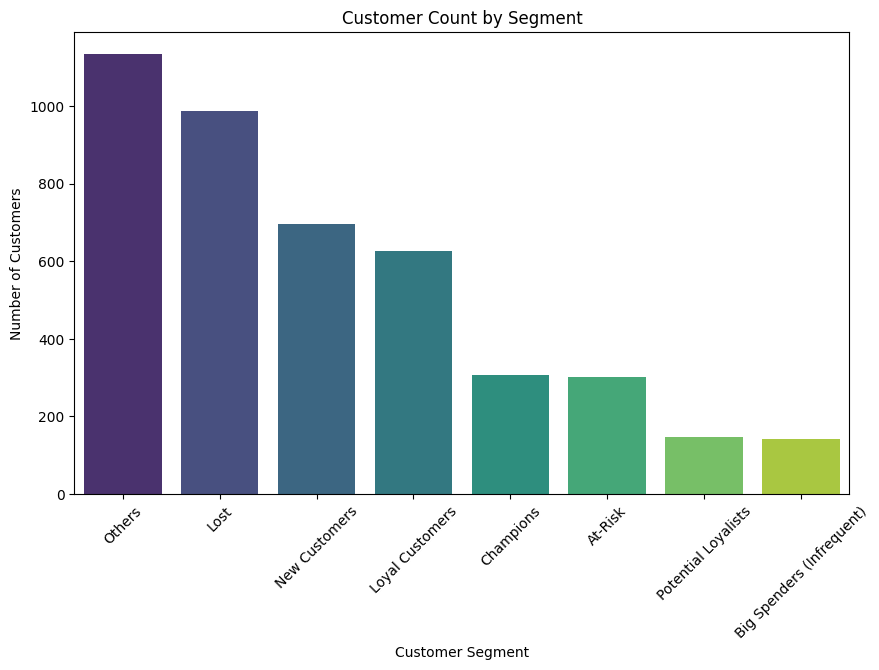

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the count of customers in each segment
segment_counts = rfm_df['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Segment', y='Count', data=segment_counts, palette='viridis')
plt.title('Customer Count by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()